# Mortgage Document Classification 

Mortgage companies often need to process large volumes of diverse document types to extract business-critical data. Today, lenders are faced with the challenge of managing a manual, slow, and expensive process to extract data and insights from documents.

To help address the issue, Amazon Textract Analyze Lending improves business process efficiency through automation and accuracy, reducing loan processing costs and providing the ability to scale quickly based on changing demand.


## Analyze Lending 
Analyze Lending is a managed intelligent document processing API that fully automates the classification and extraction of information from loan packages. Customers simply upload their mortgage loan documents to the Analyze Lending API and its pre-trained machine learning models will automatically classify and split by document type, and extract critical fields of information from a mortgage loan packet.


In this workshop, we will use Analyze Lending for Document Classification in the intelligent document processing workflow.

At the beginning of our document processing stage, it may not be obvious as do which documents are present in the mortgage packet. Using Amazon Textract Analyze Lending we will first identify these documents into their respective classes. Once we know which documents are present in the packet, we can run any kind of validation such as look for missing/required documents, extract specific document in a specific way such as ID documents and so on. The figure below explains this process.
  

<p align="center">
  <img src="./images/classification.png" alt="cfn" width="800px"/>
</p>

## Setup Notebook

In [ ]:
!python -m pip install -q amazon-textract-response-parser amazon-textract-caller amazon-textract-prettyprinter boto3 --upgrade

In [ ]:
import boto3
from textractcaller import call_textract_lending
from textractprettyprinter.t_pretty_print import convert_lending_from_trp2
from IPython.display import Image, display, HTML, JSON, IFrame
import trp.trp2_lending as tl
import json
import sagemaker
import botocore
import os
import pandas as pd
from sagemaker import get_execution_role

## Data preparation

The sample lending package `lending_package.pdf` . For this workshop, we will be a PDF formatted package, that includes the following documents:

1. Pay Slip
2. Check
3. ID Document
4. Tax form 1099-DIV
5. Bank Statement
6. Tax form W2
7. Homeowners Insurance Application Form



In [ ]:
document = 'lending_package.pdf'

In [ ]:
# variables
data_bucket = sagemaker.Session().default_bucket()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

os.environ["BUCKET"] = data_bucket
os.environ["REGION"] = region
role = sagemaker.get_execution_role()

print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

s3=boto3.client('s3')
textract = boto3.client('textract', region_name=region)

## Upload sample data to S3 bucket

The sample package has multiple documents in one file (lending_package.pdf). We will upload this to an S3 bucket for processing. 

In [ ]:
# Upload images to S3 bucket:
bucket = sagemaker.Session().default_bucket()
print(f"SageMaker Bucket: s3://{data_bucket}")

!aws s3 cp docs/lending_package.pdf s3://{data_bucket}/idp/textract/ --only-show-errors

input_file = 's3://' + bucket + '/idp/textract' + '/' + document
print(f"Lending Package uploaded to S3: {input_file}")

## Process the document with Textract Analyze Lending
We will process the lending package using the Textract Caller helper library, and then print out details for how the pages were classified. 

For more information, see [Textract Caller helper library.](https://pypi.org/project/amazon-textract-caller/)

The format of the response JSON returned is described in the Textract Analyze Lenging documentation here: [Link](https://docs.aws.amazon.com/textract/latest/dg/lending-document-classification-extraction.html)


In [ ]:
textract_json = call_textract_lending(input_document=input_file, boto3_textract_client=textract)

In [ ]:
print('Lending Package processed')
print('Pages: {}'.format(textract_json['DocumentMetadata']['Pages']))


We will next print the classifications detected for each page of the package
Type – The normalized value associated with a detection. 
For a list of all possible document types, please see [link.](https://docs.aws.amazon.com/textract/latest/dg/samples/textract_AnalyzeLending_keys.zip)

Download and unzip this file. In it you will find a CSV file, with these columns:
 - PageType: This is the document type detected. 
 - PageNumber: This is the page number within that document type. 
 - Type: These are the fields to be detected in that document


As of December 2022, the list of supported PageTypes are:

- 1003
- 1005
- 1008
- 1040
- 1065
- 1120
- 1040_SCHEDULE_C
- 1040_SCHEDULE_D
- 1040_SCHEDULE_E
- 1040_SE
- 1099_DIV
- 1099_G
- 1099_INT
- 1099_MISC
- 1099_NEC
- 1099_R
- 1099_SSA
- 1120_S
- BANK_STATEMENT
- CHECKS
- CREDIT_CARD_STATEMENT
- DEMOGRAPHIC_ADDENDUM
- HOA_STATEMENT
- HUD_92900_B
- INVESTMENT_STATEMENT
- MORTGAGE_STATEMENT
- PAYOFF_STATEMENT
- PAYSLIPS
- SSA_89
- UTILITY_BILLS
- VBA_26_0551
- W_2
- W_9

In [ ]:
results = textract_json['Results']
    
for page in results:
    print("Page Number: {}".format(page["Page"]), "Page Classification: {}".format(page["PageClassification"]["PageType"]))

----

### How does Textract Analyze Lending classify the document pages?

Let's take a look at the full JSON response from AnalyzeLending. The `results` variable consists of a list with 7 elements for each of the 7 pages in the `lending_package.pdf` document.

In [ ]:
display(JSON(results, expanded=False))

Let's look at the JSON for the first page in the document.

In [ ]:
display(JSON(results[0], expanded=True))

For page 1 of the document, Textract Analyze Lending classified the page as a `PAYSLIP`. On the payslip, it will look for key payslip fields. For Example:
- Start Date: `___` (as there is none on this payslip)
- End date: 7/18/2008
- Pay Date: 7/25/2008
- Borrower Name: John Stiles

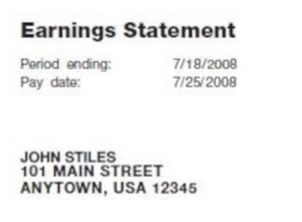



Note that the last page is an unsupported document type, a Homeowners Insurance Application Form. In module 2, we will process the fields extracted from each of the documents. 

Let's next store the JSON output to a file. A file named "lending-doc-output.json" will be created locally on this SageMaker Studio instance, in the `aws-ai-intelligent-document-processing directory/industry/mortgage` directory. 
We will use the same JSON file for our extractions in the next module. 

In [ ]:
json.dump(textract_json, open("lending-doc-output.json", "w"))

---
## Use the Textract Response Library to convert the response to an easier format to work with

We are calling the [Textract Response Parser Library](https://pypi.org/project/amazon-textract-response-parser/) and then convert the Textract Analyze Lending JSON response to a flattened array for CSV export.


The convert_lending_from_trp2() method returns a list of `[{page_classification}_{page_number_within_document_type}, page_number_in_document, key, key_confidence, value, value_confidence, key-bounding-box.top, key-bounding-box.height, key-bb.width, key-bb.left, value-bounding-box.top, value-bb.height, value-bb.width, value-bb.left]`

In [ ]:
trp2_doc: tl.TFullLendingDocument = tl.TFullLendingDocumentSchema().load(textract_json)
lending_array = convert_lending_from_trp2(trp2_doc)

A file named "lending-doc-output.csv" will be created locally on this SageMaker Studio instance, `aws-ai-intelligent-document-processing directory/industry/mortgage` directory. 
Open the file and use the  CSV display to view each element extracted. 
You can also download the file to view locally on your laptop in your favorite spreadsheet application. 

In [ ]:
import csv
  
index_fields = ['{page_classification}_{page_number_within_document_type}', 'page_number_in_document', 'key','key_confidence','value','value_confidence','key-bounding-box.top','key-bounding-box.height','key-bb.width','key-bb.left','value-bounding-box.top','value-bb.height','value-bb.width','value-bb.left'] 

with open('analyze-lending-output.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(index_fields)
    csv_writer.writerows(lending_array)


Open the CSV file (use the panel on the left, in the `mortgage` directory) and observe the fields extracted, for example:

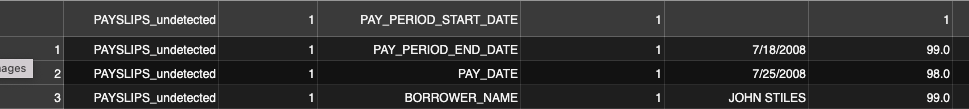